#                     Instituto Balseiro - Física Experimental II
#                       Implementación de un PLL en Python
###                          Ignacio Carraro Haddad, Facundo Sheffield

## Introducción:

Se conoce como Phase Locked Loop (PLL) o lazo de seguimiento de fase a un sistema de control capaz de generar una señal de salida que sigue a la de entrada en frecuencia y fase. Debido a sus características, el sistema permite obtener señales estables, sincronizar y demodular frecuencias. Estas propiedades hacen que sea usado frecuentemente en el área de las comunicaciones.

![PLL_graph0.png](https://raw.githubusercontent.com/Filler-username222/PLL/master/PLL_graph0.png)
<h5><center>Figura 1: Esquema básico de un PLL</center></h5>

El esquema básico de un PLL puede verse en el diagrama de bloques de la figura 1. Este consta de las siguientes etapas:<br>
    1) El ***detector de fases*** genera una señal con una componente continua proporcional a la diferencia de fase $\Delta \phi$ entre la entrada y la salida del VCO. El mismo puede ser implementado de distintas maneras, como con un multiplicador de cuatro cuadrantes o uno con lógica XOR.<br>
    2) La señal de salida del detector es luego filtrada por un ***filtro pasa bajos*** para atenuar la componente alterna y obtener una señal lo más continua posible. El mismo, similar al detector de fases, puede ser implementado de distintas maneras. En particular para esta experiencia, se utilizó un RC y un Lead-lag activo,<br>
    3) La señal continua filtrada, la cual es proporcional a $\Delta \phi$, ingresa al ***VCO*** (oscilador controlado por voltaje). El cual genera una señal periódica cuya frecuencia es  proporcional a la tensión (desfasaje) que recibe. Luego se termina la iteración del ciclo cuando la salida del VCO va a parar al detector de fase para continuar con la retroalimentación.<br>

Como resultado de este ciclo la señal de salida del VCO 'sigue' a la entrada después de una etapa transitoria.<br>
    En este trabajo se busca simular a través de un programa de computadora el funcionamiento de un PLL y comprobar su funcionamiento y propiedades con señales que suelen utilizarse con un PLL real.

## Fuente de Señal

Para simular el comportamiento del PLL, se necesita en primer lugar generar la señal de entrada al
PLL, xr(t). Esta señal será una señal sinusoidal de una determinada frecuencia, y con una
fase inicial establecida.

***Ejercicio 1.*** Construir una función en Python que genere N muestras de la señal de entrada al
PLL: ***fuente***(f0, Ts, fase inicial, N). Donde f0 es la frecuencia de la señal, Ts es el período entre
muestras (período de muestreo), fase inicial es la fase inicial de la señal, y N es el número total de
muestras de la señal a generar.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,fftfreq,fftshift
from scipy.signal import unit_impulse,butter,lfilter,lfilter_zi

# Se definen además una función plotS para graficar, TF para realizar la FFT, dc para simular una señal continua y
# delta para simular una delta de dirac.

def fuente(f0, Ts, fi, N):  # fi -> fase inicial
    a = np.linspace(0.0, N*Ts, N)  # Returns evenly spaced numbers over an interval. (Start, end, deltax)
    s = np.sin(2*a*np.pi*f0+fi) # sin(array())=array(sin())
    return a,s

def solape(f0,f,Ts,fi,N,Ns):#permite "juntar" dos señales con la misma frecuecnia pero con un salto de fase en una muestra dada
    a1,s1=fuente(f0,Ts,fi,Ns)#señal inicial
    a2,s2=fuente(f0,Ts,(fi+2*np.pi*f0*Ns*Ts+f),N-Ns)#señal con el salto de fase
    a2=np.linspace(Ns*Ts,N*Ts,N-Ns)
    a1=np.append(a1,a2)
    s=np.append(s1,s2)
    return a1,s

def plotS(a,s):
    plt.scatter(a, s, np.pi*3, '0', alpha=0.5)  # scatterplot -> plots 2D values as points
    # (x,y,tamaño de marcador,RGB(c)[Hexa], alpha ->transparencia de los ptos )
    plt.title('Señal')
    plt.xlabel('tiempo(s)')
    plt.ylabel('Tensión(V)')
    plt.show()
    
def TF(N,Ts,x,graph=False):  # x array, N num de muestras
    F = fft(x)  # Devuelve el array transformado
    f = fftfreq(N,Ts)  # Devuelve las freq con espaciado Ts
    f = fftshift(f)  # pone la segunda mitad del array adelante de la primera
    if(graph==True):
        Fplot=fftshift(F)
        plt.plot(f, 1.0/N * np.abs(Fplot))  # el abs le hace abs a c/ elem
        plt.title('Dominio de frecuencias')
        plt.xlabel('Frecuencia(Hz)')
        plt.ylabel('Potencia(UA)')
        plt.grid()  # crea el grid 
        plt.show()
    return F

def dc(V, Ts, N):  #genera una señal de tensión continua
    a = np.linspace(0.0, N*Ts, N)
    s=np.full(N,V)  # array lleno de V
    return a,s

def dirac(Ts,N,No):#genera una delta de dirac
    a = np.linspace(0.0, N*Ts, N)
    x=10*unit_impulse(N,No)
    return a,x



***Ejercicio 2.*** Utilizando la función construida representar la señal de entrada al PLL para N = 1000
muestras, f0 = 1 kHz, fase inicial = π/2, y período de muestreo: Ts = 1/(100f0).
Con la función construida podemos fácilmente generar una señal de entrada al PLL con un salto
de fase en un instante temporal determinado

<IPython.core.display.Javascript object>


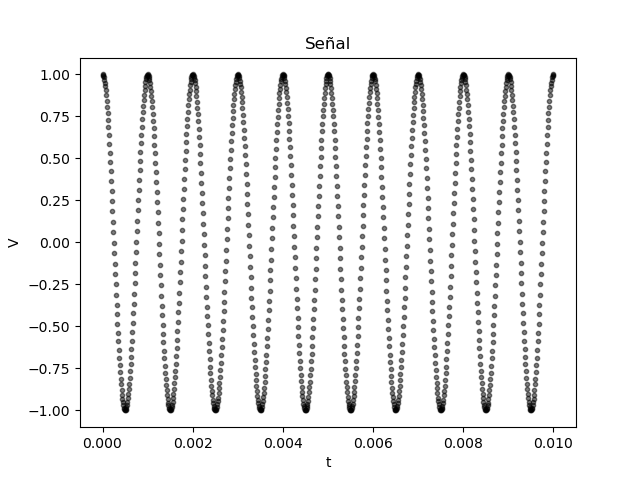

In [2]:
N=1000
f0=1000
Ts=1/(100*f0)
fi=np.pi/2

%matplotlib notebook
a, s = fuente(f0,Ts,fi,N) 
plotS(a,s)

***Ejercicio 3.*** Utilizando la función construida representar la señal de entrada al PLL en las mismas
condiciones anteriores, pero introduciendo un salto de fase de valor π en la muestra: N/2.

<IPython.core.display.Javascript object>


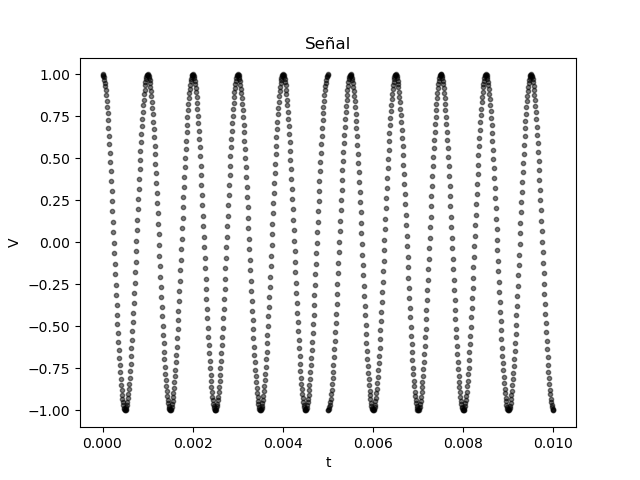

In [3]:
N=1000
f0=1000
Ts=1/(100*f0)
fi=np.pi/2

%matplotlib notebook
a, s = solape(f0,np.pi,Ts,fi,N,N//2) 
plotS(a,s)

## Detector de fases

Para simular el detector de fases se utilizó en primer lugar el tipo de detector más fácil, es decir, un multiplicador de señal ideal:

***Ejercicio 4.*** Construya una función en Python que implemente el detector de fases entre una
muestra temporal de la señal de entrada $x_r$ y una muestra temporal de la señal del VCO ($x_v = x_{VCO}$):
***detector***($x_r, x_v$).

In [2]:
def detector(xr, xv):
    xs = xr * xv
    return xs

***Ejercicio 5.*** Usando las funciones anteriores construya dos señales de frecuencia ($f_0$ = 1 kHz), una
con fase inicial cero y la otra con fase inicial (π/4). Pasar las dos señales por el detector de fases.
Tenga en cuenta que debe pasar el detector muestra a muestra con un bucle temporal. Representar la
señal resultante en tiempo y frecuencia. Comentar el resultado obtenido. Interpretar el significado de
la componente continua obtenida.

<IPython.core.display.Javascript object>


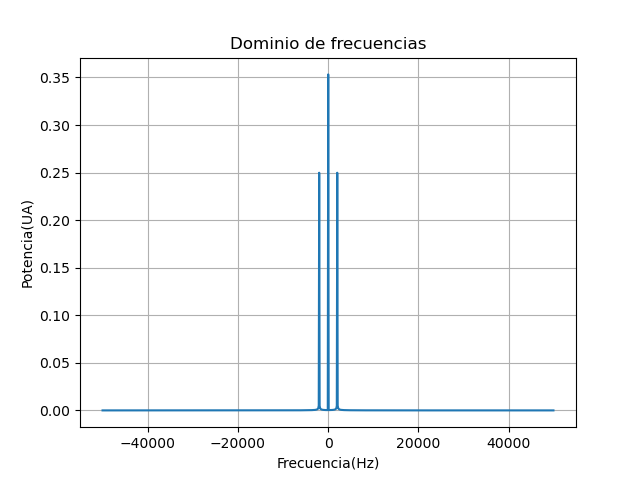

In [58]:
f0 = 1000
Ts = 1/ (100 * f0)
fi = np.pi / 2
N = 1000

t, s1 = fuente(f0, Ts, 0, N)

t2, s2 = fuente(f0, Ts, np.pi / 4, N)  # desfase pi/4

xo = np.array(detector(s1[0],s2[0]))
for i in range(1,N):
    xo = np.append(xo, detector(s1[i],s2[i]))
%matplotlib notebook
F=TF(N,Ts,xo,graph=True)


#plotS(t, s1)
#plotS(t, xo)




***Ejercicio 6.*** Repetir el ejercicio con dos señales, una con fase inicial cero y la otra con fase inicial
(π/2). ¿Qué fase detecta el detector de fase en este caso?. Comentar los resultados obtenidos.

<IPython.core.display.Javascript object>


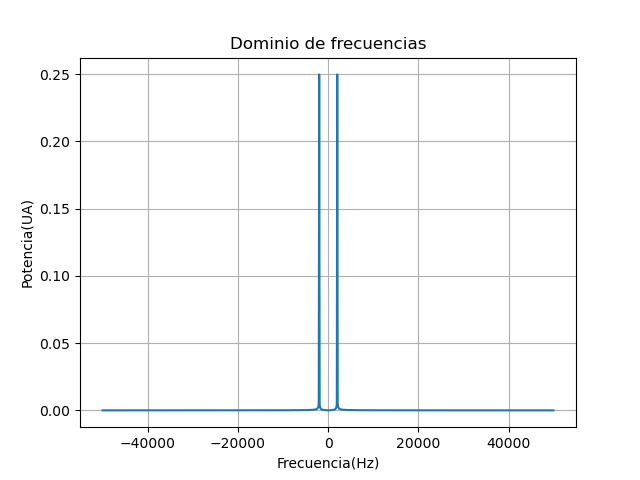

In [59]:
f0 = 1000
Ts = 1/ (100 * f0)
fi = np.pi / 2
N = 1000

t, s1 = fuente(f0, Ts, 0, N)

t2, s2 = fuente(f0, Ts, np.pi / 2, N)  # desfase pi/2

xo = np.array(detector(s1[0],s2[0]))
for i in range(1,N):
    xo = np.append(xo, detector(s1[i],s2[i]))
%matplotlib notebook
F=TF(N,Ts,xo,graph=True)


#plotS(t, s1)
#plotS(t, xo)


En este caso vemos que la señal de salida del detector no tiene componente continua, sino que se duplica la frecuencia de la señal. Por lo que el detector indica un desfasaje nulo.

### Ganancia del detector y linealidad:

El propósito de cualquier detector de fase es producir una señal proporcional a la diferencia de fase entre las señales de entrada, cuya tensión será de la forma: $v_e(t)=K_D[\Phi_{1}-\Phi_{2}]$, donde la constante $K_D$ es la ganancia del detector. Como se está trabajando con un detector que en escencia es un multiplicador, la ganancia vendrá dada por el producto de las ondas senoidales de entrada. Como se sabe que este producto es 
\begin{equation*} 
[cos(\Phi_{1}-\Phi_{2})-cos(2wt+\Phi_{1}+\Phi_{2})]/2
\end{equation*} 
se observa que habría una dependencia cosenoidal entre la tensión promedio y la fase. Por ende se realizó un ajuste lineal para determinar el valor de de $K_D$ y su rango de validez:

![PLL_KD.png](https://raw.githubusercontent.com/Filler-username222/PLL/master/PLL_KD.png)

Como puede verse, se determinó que el detector posee una respuesta lineal para diferencias de fase desde 0,5 hasta 2,5 radianes. El valor de $K_D$ obtenido fue $|K_D|=(0,448\pm0,004)$.

## Filtro

***Ejercicio 7.*** Utilizando todas las consideraciones anteriores, construir una función en Python que
sirva para realizar el filtrado muestra a muestra de la señal de entrada ($x_d$): ***filtro***($x_d$, estado inicial,
tipo, C, R1, R2, Ts). La variable (tipo) podrá tomar los valores "rc" y "lead-lag activo", para implementar
en cada caso la correspondiente función de transferencia.
Para el filtro “rc” y el “lead-lag activo” tomar como parámetros de entrada el coeficiente de amortiguamiento (ξ), y la pulsación propia ($w_n$). 

In [3]:
def rc(xd, Ts,zheta,wn,ei, order=1):
    b,a=butter(order,zheta*wn*4*Ts,'low')
    zi = lfilter_zi(b, a)
    xs,_ = lfilter(b, a, np.array([xd]), zi=zi*ei)
    return xs

def lead_lag(xd, Ts, zheta, wn, Kv, ei): 
    
    if wn==0 or zheta==0:
        print("Error. Incertar valores no nulos de wn y zheta.")
        return 1
    
    T2=2*zheta/wn
    T1=Kv/(wn*wn)
    
    fs=1/Ts
    wc=1/(T1+T2) 
    fc=wc/(2*np.pi)
    wc_norm=fc/(fs/2)
    
    b,a=butter(1,wc_norm,'low')
    zi = lfilter_zi(b, a)
    xs,_ = lfilter(b, a, np.array([xd]), zi=zi*ei)
    return xs


def filtro(xd,Ts,zheta,wn,Kv,ei,tipo='rc'):   
    if 'rc' in tipo:
        return rc(xd,Ts,zheta,wn,ei)
    elif 'lead_lag' in tipo:
        return lead_lag(xd, Ts, zheta, wn, Kv, ei)
    else:
        print("Error. El tipo debe ser 'rc' o 'lead_lag'. ")



***Ejercicio 8.*** Introducir una función $\delta$ como señal de entrada al filtro "rc", con el fin de obtener la
respuesta al impulso y la función de transferencia del filtro. Dibujar la respuesta al impulso y la función
de transferencia obtenida para los tres casos siguientes: ($w_n$ = 2, $\xi$ =
$\frac{\sqrt{
2}}{2}$), ($w_n$ = 100, $\xi$ =
$\frac{\sqrt{
2}}{2}$) y
($w_n$ = 2, $\xi$ = 5). Comentar cómo varía en cada caso la respuesta del filtro.

<IPython.core.display.Javascript object>


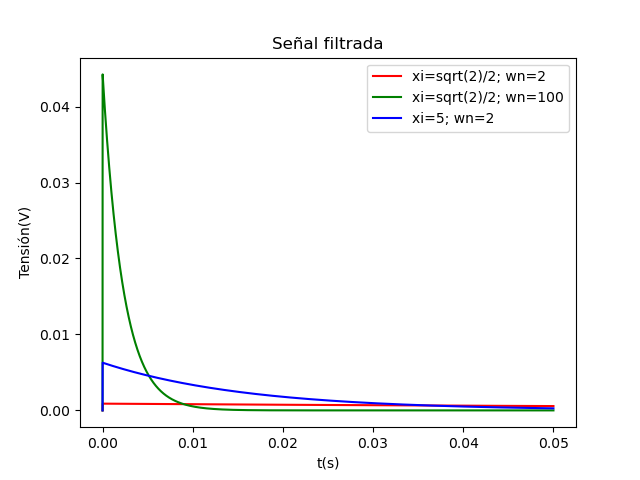

In [63]:
Ts = 1/ (100 * f0)
N = 5000
t,d=dirac(Ts,N,1) #delta
df1=np.array(filtro(d[0],Ts,np.sqrt(2)/2,2.,0,0,"rc")) #filtramos a la delta bajo las tres condiciones que se piden
df2=np.array(filtro(d[0],Ts,np.sqrt(2)/2,100.,0,0,"rc"))
df3=np.array(filtro(d[0],Ts,5.,2.,0,0,"rc"))
for i in range(1,N):
    df1=np.append(df1,filtro(d[i],Ts,np.sqrt(2)/2.,2.,0,df1[i-1],"rc"))
    df2=np.append(df2,filtro(d[i],Ts,np.sqrt(2)/2.,100.,0,df2[i-1],"rc"))
    df3=np.append(df3,filtro(d[i],Ts,5.,2.,0,df3[i-1],"rc"))
%matplotlib notebook
fig, ax = plt.subplots()
ax.plot(t,df1,'r',label='xi=sqrt(2)/2; wn=2')
ax.plot(t,df2,'g',label='xi=sqrt(2)/2; wn=100')
ax.plot(t,df3,'b',label='xi=5; wn=2')
plt.xlabel('t(s)')
plt.ylabel('Tensión(V)')
plt.title('Señal filtrada')
leg=ax.legend()


Vamos a aplicar estos filtros a la señal de salida del detector de fases. Para ello tomar las dos señales
generadas anteriormente con la función fuente, una con fase inicial cero y la otra con fase inicial $\pi$/4
(frecuencia portadora: $f_o$ = 1 kHz). Pasar las señales por el detector de fases (función detector).

***Ejercicio 9.*** Tomando N = 2000 muestras, aplicar el filtro "rc" en los tres casos anteriores: (wn = 2,
$\xi$ =
$\frac{\sqrt{
2}}{2}$), (wn = 100, $\xi$=$\frac{\sqrt{
2}}{2}$) y (wn = 2, $\xi$ = 5). Representar la señal después del filtro tanto en
tiempo como en frecuencia.Comentar las diferencias obtenidas en los tres casos.

<IPython.core.display.Javascript object>


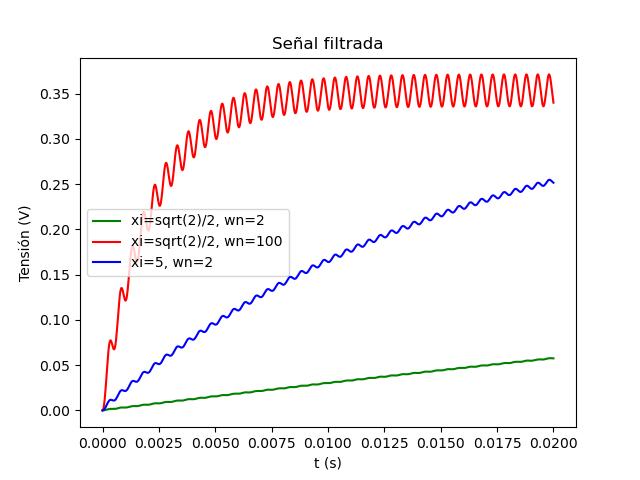

In [6]:
f0 = 1000
Ts = 1/ (100 * f0)
fi = np.pi / 4
N = 2000

t, s1 = fuente(f0, Ts, 0, N)

t2, s2 = fuente(f0, Ts, fi, N)  # desfase pi/4

xo = np.array(detector(s1[0],s2[0]))
for i in range(1,N):
    xo = np.append(xo, detector(s1[i],s2[i]))
df1=np.array(filtro(xo[0],Ts,np.sqrt(2)/2,2.,0,0,"rc"))
df2=np.array(filtro(xo[0],Ts,np.sqrt(2)/2,100.,0,0,"rc"))
df3=np.array(filtro(xo[0],Ts,5.,2.,0,0,"rc"))
for i in range(1,N):
    df1=np.append(df1,filtro(xo[i],Ts,np.sqrt(2)/2.,2.,0,df1[i-1],"rc"))
    df2=np.append(df2,filtro(xo[i],Ts,np.sqrt(2)/2.,100.,0,df2[i-1],"rc"))
    df3=np.append(df3,filtro(xo[i],Ts,5.,2.,0,df3[i-1],"rc"))
%matplotlib notebook
fig, ax = plt.subplots()
ax.plot(t,df1,'g',label='xi=sqrt(2)/2, wn=2')
ax.plot(t,df2,'r',label='xi=sqrt(2)/2, wn=100')
ax.plot(t,df3,'b',label='xi=5, wn=2')
plt.xlabel('t (s)')
plt.ylabel('Tensión (V)')
plt.title('Señal filtrada')
leg=ax.legend()

***Ejericio 10.*** Repetir el ejercicio 9 pero aplicando el filtro “lead-lag activo”, con los valores: ($w_n$ = 2,
ξ =
$\frac{\sqrt{
2}}{2}$), ($w_n$ = 100, ξ =
$\frac{\sqrt{
2}}{2}$) y ($w_n$ = 2, ξ = 0,1). Comentar los resultados obtenidos para este
filtro.


<IPython.core.display.Javascript object>


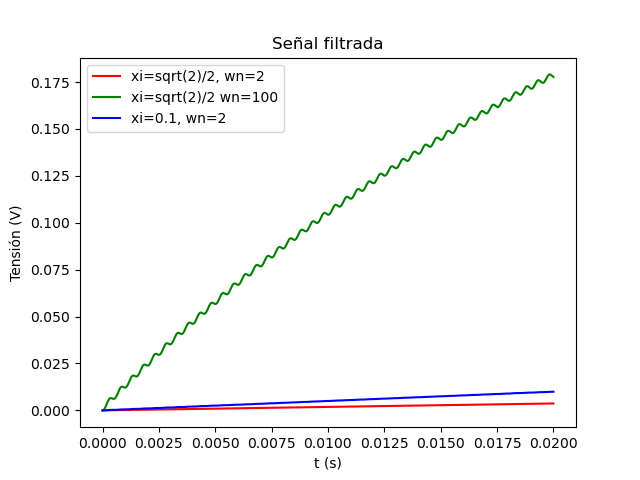

In [7]:
f0 = 1000
Ts = 1/ (100 * f0)
fi = np.pi / 4
N = 2000
Kv = 1 # Se considera Kv = 1 (no hay ganancia) para los propósitos del ejercicio

#lead_lag(xd, Ts, zheta, wn, Kv, ei)

df10=np.array(filtro(xo[0],Ts,np.sqrt(2)/2,2,Kv,0,"lead_lag" ))
df20=np.array(filtro(xo[0],Ts,np.sqrt(2)/2,100,Kv,0,"lead_lag"))
df30=np.array(filtro(xo[0],Ts,0.1,2.0,Kv,0,"lead_lag"))



for i in range(1,N):
    df10=np.append(df10,filtro(xo[i],Ts,np.sqrt(2)/2,2,Kv,df10[i-1],"lead_lag" ))
    df20=np.append(df20,filtro(xo[i],Ts,np.sqrt(2)/2,100,Kv,df20[i-1],"lead_lag"))
    df30=np.append(df30,filtro(xo[i],Ts,0.1,2.0,Kv,df30[i-1],"lead_lag"))

%matplotlib notebook
fig, ax = plt.subplots()
ax.plot(t,df10,'r',label='xi=sqrt(2)/2, wn=2')
ax.plot(t,df20,'g',label='xi=sqrt(2)/2 wn=100')
ax.plot(t,df30,'b',label='xi=0.1, wn=2')
plt.xlabel('t (s)')
plt.ylabel('Tensión (V)')
plt.title('Señal filtrada')
leg=ax.legend()

## VCO: Oscilador Controlado por Voltaje

El propósito del VCO es generar una señal senoidal de la forma $x_v(t)=sin(\theta(t))$, cuya frecuencia será la suma de una frecuencia propia $f_0$ y una desviación proporcional a la tensión de entrada $Kx_c(t)$, donde $K$ es la ganancia que posee el VCO.

Sabiendo esto es posible obtener una expresión para la frecuencia instantánea de la forma: 
$\theta(t+T_s)=\theta(t)+2\pi f(t)T_s$

***Ejercicio 11.*** En base al desarrollo anterior, construir una función que, dada la frecuencia actual
($f = f_0 +Kx_c(t)$) y la fase en el instante t, calcule la fase en el instante siguiente (t+$T_s$): ***fase final*** =
***fase***($T_s$,f,fase inicial). Al construir la función, asegurarse que la fase de salida estará comprendida
entre el intervalo (0, 2π).
Con la función construida, es posible simular el comportamiento del VCO en cada muestra de la
siguiente forma:

ph = fase($T_s,f_0 + K x_c,ph$)  (Calcula la fase en el siguiente instante.)

$V_{vco}(i) = sin(ph)$  (Señal de salida del VCO.)

siendo ($x_c$) la tensión de control al VCO (ver Figura 1). El código mostrado estará dentro del bucle
que barre todas las muestras de la señal (índice i).

La aplicación mas inmediata de la función que acabamos de construir es la implementación de
un modulador de FM. Vamos a tomar una frecuencia central de oscilación del VCO de: $f_0$ = 1 kHz.
Tomaremos como señal moduladora una señal sinusoidal de frecuencia: $f_m$ = 40 Hz. Tomar para este
análisis una frecuencia de muestreo de: fs = 10$f_0$, con un número total de muestras: N = 1000.

In [8]:
def fase(Ts,f,fi):  # fase instantánea o fase final
    a = (fi+(2*np.pi*f*Ts))%(2*np.pi)
    return a

    
def modular(xc,Ts,f0,K,fi):
    V_vco = np.sin(fase(Ts, f0+K*xc, fi))
    return V_vco

***Ejercicio 12.*** Generar en primer lugar la señal moduladora (o señal de control, xc(t)) usando
la función **fuente** ya construida (tomar como fase inicial cero). Representar la señal en tiempo y
frecuencia.

<IPython.core.display.Javascript object>


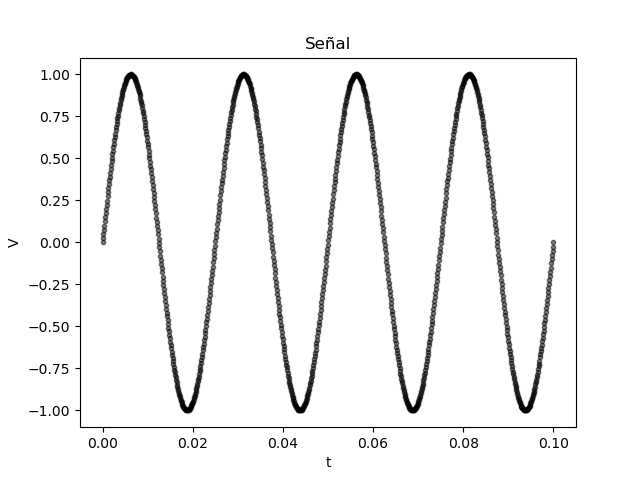

In [12]:
f0=1000
Ts=1/(10*f0)
N=1000
K=0
fi=0
Vo=5
fm=40

t,xc=fuente(fm,Ts,0,N)
#t,xc=dc(Vo,Ts, N) # señal continua

%matplotlib notebook
plotS(t,xc)
#F=TF(N,Ts,xc,graph=True)

***Ejercicio 13.*** Obtener la señal a la salida del VCO sin introducir señal de control (K = 0).
Representar la señal en tiempo y frecuencia. Comentar el resultado obtenido

In [13]:
xo=[]
for i in range(N):
    fi = fase(Ts, f0+K*xc[i],fi)
    xo = np.append(xo, modular(xc[i], Ts, f0, K, fi))
    
%matplotlib notebook
#plotS(t, xo)

#TF(N,Ts,xo,True)

Se puede observar de la transformada que la salida del VCO cuando K=0 es la una onda senoidal cuya frecuencia es la frecuencia natural del dispositivo, lo cual simula el comportamiento real de un VCO.

***Ejercicio 14.*** Obtener la señal a la salida del VCO introduciendo la señal de control con una
ganancia K = 100. Dibujar la señal obtenida en tiempo y frecuencia. ¿Ha obtenido la señal modulada
en frecuencia?.

In [14]:
K=100
xv=[]
for i in range(N):
    fi = fase(Ts, f0+K*xc[i],fi)
    xv = np.append(xv, modular(xc[i], Ts, f0, K, fi))
    
%matplotlib notebook
#plotS(t, xv)

#TF(N,Ts,xv,True)

Se pueden ver de la tranformada los picos centrados a 1000Hz y apartados 40Hz, lo que indica que efectivamente se ha obtenido una señal que está modulada en frecuencia.

### Ganancia del VCO y linealidad:


Para que el PLL funcione como un sistema lineal, todos sus componentes deben comportarse de manera lineal. En el caso del VCO, la linealidad implicaría: 
\begin{equation*} 
w_{out}=w_0+K_OV_{cont}
\end{equation*} 
donde $w_{out}$ sería la frecuencia de la salida, $w_0$ la frecuencia natural del VCO, $V_{cont}$ la tensión continua de entrada y $K_O$ la ganancia del VCO. 

 Para obtener un rango lineal de funcionamiento lo que se hizo fue tomar un cierto valor de $K_O$, e ir introduciendo valores distintos de tensión hasta ver que la respuesta no sea lineal. Se observó que si la frecuencia de salida era mayor a 5000Hz, la respuesta dejaba de ser lineal, por lo que se tomó este valor como cota. A continuación se muestra un ejemplo del procedimiento empleado:


In [15]:
Ts=1/10000
f0=1/Ts
N=1000
K=100
fi=0
Vo=55

t,xc=dc(Vo,Ts, N)


xo=np.sin([fi])
for i in range(1, N):
    fi = fase(Ts, f0+K*xc[i],fi)
    xo = np.append(xo, modular(xc[i], Ts, f0, K, fi))
%matplotlib notebook
#plotS(t,xc)
#TF(N,Ts,xo,True)

## PLL

Utilizando todas las funciones realizadas hasta ahora, construir un programa que simule el funcionamiento
de un PLL. Vamos a simular el funcionamiento de un PLL, cuya frecuencia de oscilación
libre es de $f_o$ = 1 kHz. La señal de entrada al PLL será una señal de la misma frecuencia (sin error de
frecuencia), y con error de fase inicial de $\pi$/2 . Tomar además $N$ = 3000 muestras y una frecuencia de
muestreo de $f_s$ = 100$f_o$. En estas condiciones realizar los siguientes experimentos.

In [10]:
def PLL(x,fo,Ts,fi,N,K,zheta,wn,Kv,tipo):
    xv=np.array([modular(0,Ts,fo,K,fi)])
    fi=fase(Ts,fo,fi)
    xd=detector(x[0],xv[0])#iterar muestra a muestra
    xc=filtro(xd,Ts,zheta,wn,Kv,0,tipo)
    xcv=xc
    xcp=xcv
    for i in range(1,N):
        f=modular(xc,Ts,fo,K,fi)
        xv=np.append(xv,f)
        xd=detector(x[i],xv[i])
        xc=filtro(xd,Ts,zheta,wn,Kv,xcv,tipo)
        xcv=xc
        xcp=np.append(xcp,xcv)
        fi=fase(Ts,fo+K*xc,fi)
    return xv,xcp
fo=1000
Ts=1/(100*fo)
K=1000
N=3000
t,x=fuente(fo,Ts,0,N)

***Ejercicio 15.*** Utilizando el filtro "rc", ajustar los parámetros del bucle a ($\xi$ =
$\frac{\sqrt{
2}}{2}$, wn = 180).
Representar la señal a la salida del filtro con el fin de comprobar el tipo de amortiguamiento del bucle.
Repetir con un factor de amortiguamiento de ($\xi$ = 0,3) y ($\xi$ = 2,0) para comprobar como cambia el
amortiguamiento del bucle con el parámetro de amortiguamiento $\xi$. Representar todas las gráficas.

<IPython.core.display.Javascript object>


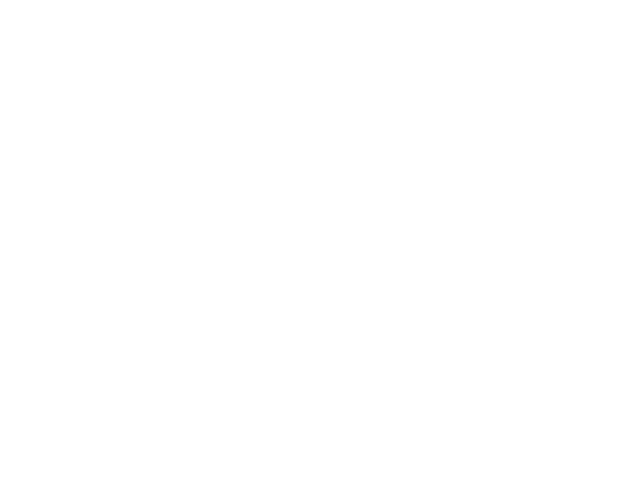

In [11]:
xi1=np.sqrt(2)/2
xi2=0.3
xi3=2.
wn=180
fi=np.pi/2
xo1,xc1=PLL(x,fo,Ts,fi,N,K,xi1,wn,0,"rc")
xo2,xc2=PLL(x,fo,Ts,fi,N,K,xi2,wn,0,"rc")
xo3,xc3=PLL(x,fo,Ts,fi,N,K,xi3,wn,0,"rc")
%matplotlib notebook
plt.subplot(2,2,1)
plt.plot(t,xc1)
plt.subplot(2,2,2)
plt.plot(t,xc2)
plt.subplot(2,2,3)
plt.plot(t,xc3)
plt.show()

***Ejercicio 16.*** Para los tres casos anteriores representar el diagrama de Lissajous y la gráfica de
error entre la señal de salida del VCO y la señal de entrada ¿Consigue engancharse el PLL en fase?.

<IPython.core.display.Javascript object>


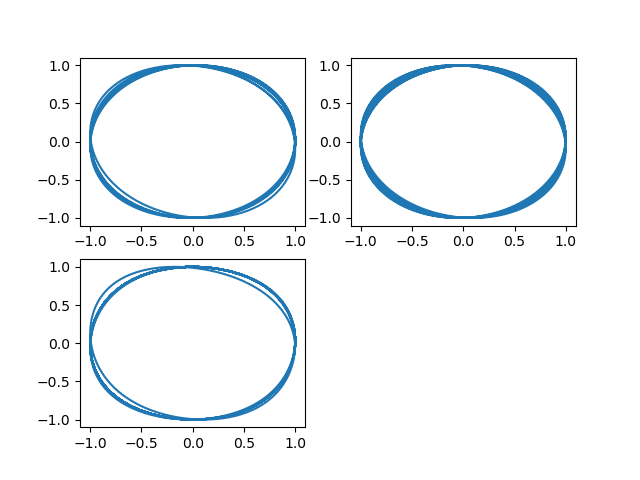

In [12]:
%matplotlib notebook
plt.subplot(2,2,1)
plt.plot(xo1,x)
plt.subplot(2,2,2)
plt.plot(xo2,x)
plt.subplot(2,2,3)
plt.plot(xo3,x)
plt.show()

#### Diagramas de error de fase:

<IPython.core.display.Javascript object>


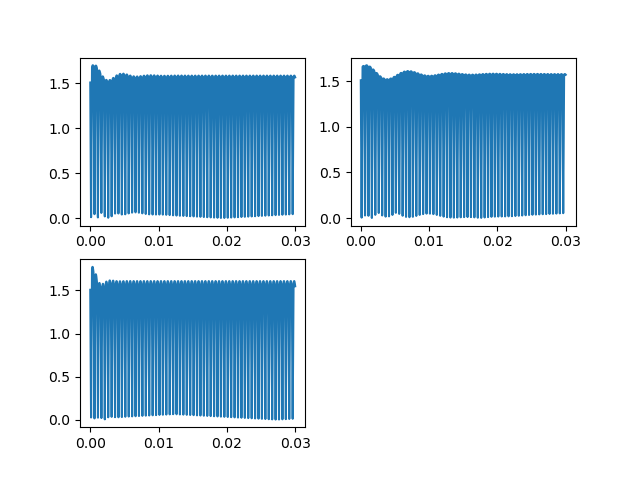

In [13]:
%matplotlib notebook
#plt.plot(t,abs(np.arcsin(x)-np.arcsin(xo1)))
plt.subplot(2,2,1)
plt.plot(t,abs(np.arcsin(xo1)-np.arcsin(x)))
plt.subplot(2,2,2)
plt.plot(t,abs(np.arcsin(xo2)-np.arcsin(x)))
plt.subplot(2,2,3)
plt.plot(t,abs(np.arcsin(xo3)-np.arcsin(x)))
plt.show()

***Ejercicio 17.*** Para comprobar como afecta el ancho de banda del filtro, repetir el ejercicio con
$\xi$ =
$\frac{\sqrt{
2}}{2}$, wn = 120). ¿Qué ocurre al disminuir el ancho de banda del filtro?.

<IPython.core.display.Javascript object>


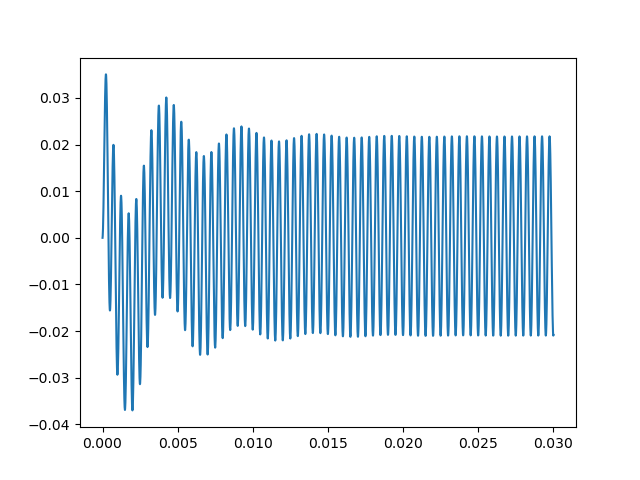

In [14]:
xi=np.sqrt(2.)/2
wn=120
fi=np.pi/2
xo,xc=PLL(x,fo,Ts,fi,N,K,xi,wn,0,"rc")
%matplotlib notebook
plt.plot(t,xc)

<IPython.core.display.Javascript object>


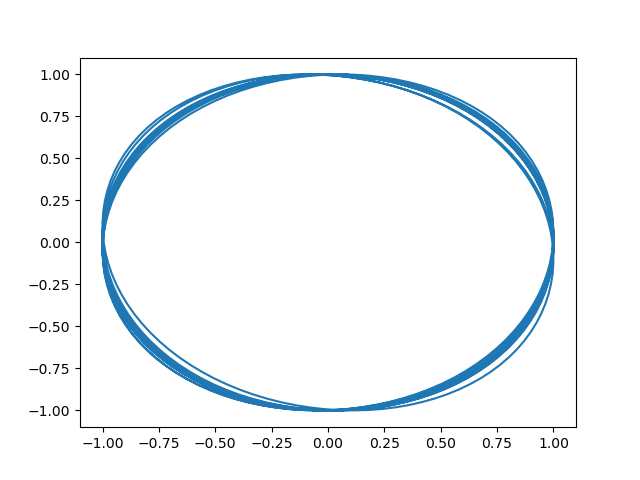

In [21]:
%matplotlib notebook
plt.plot(xo,x)

<IPython.core.display.Javascript object>


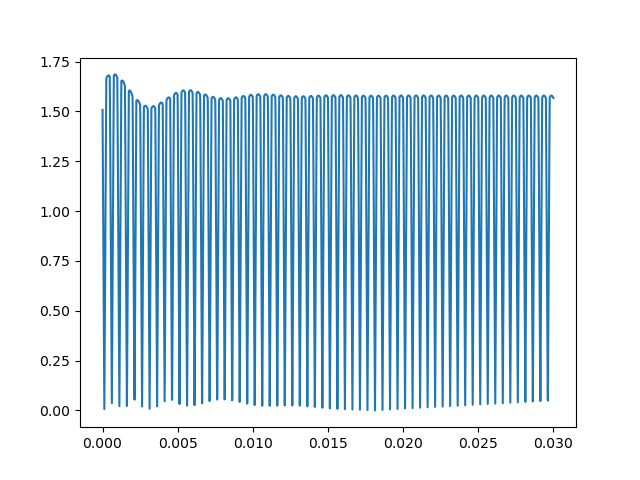

In [22]:
%matplotlib notebook
plt.plot(t,abs(np.arcsin(xo)-np.arcsin(x)))

***Ejercicio 18.*** Utilizando el filtro "lead-lag activo", comprobar el enganche del PLL para unos
parámetros de bucle: ($\xi$ =
$\frac{\sqrt{
2}}{2}$, wn = 40).

<IPython.core.display.Javascript object>


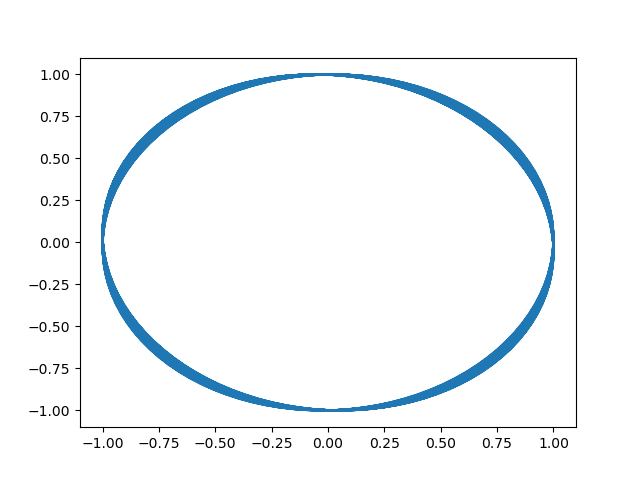

In [23]:
xi1=np.sqrt(2)/2
wn=40

fi=np.pi/2
xo,xc=PLL(x,fo,Ts,fi,N,K,xi1,wn,1000,"lead_lag")


%matplotlib notebook

#plt.plot(t,xc)
plt.plot(xo,x)
#plt.plot(t,abs(np.arcsin(xo)-np.arcsin(x)))
plt.show()



***Ejercicio 19.*** Comprobar el enganche del filtro si se aumenta el ancho de banda a: ($\xi$ =
$\frac{\sqrt{
2}}{2}$,
wn = 120) ¿Se comporta el PLL igual que antes con el ancho de banda del filtro?.

<IPython.core.display.Javascript object>


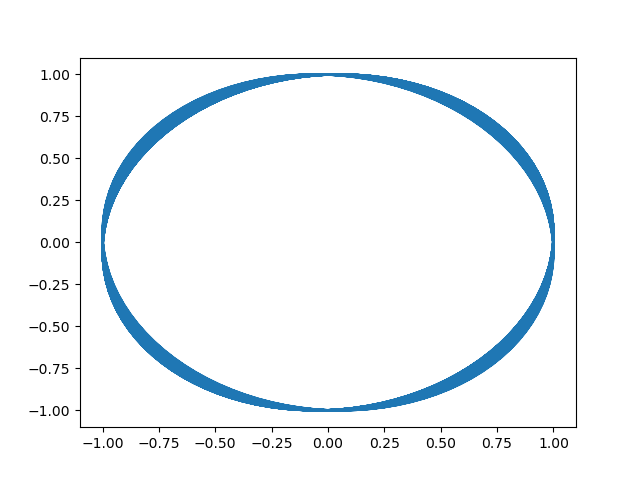

In [24]:
xi1=np.sqrt(2)/2
wn=120

fi=np.pi/2
xo,xc=PLL(x,fo,Ts,fi,N,K,xi1,wn,1000,"lead_lag")


%matplotlib notebook

#plt.plot(t,xc)
plt.plot(xo,x)
#plt.plot(t,abs(np.arcsin(xo)-np.arcsin(x)))
plt.show()


# Errores de fase

A la señal anterior, introducir en la muestra ($N$/2) un error de fase de ($\pi$/4). Dibujar en cada caso
la señal de error y el diagrama de Lissajous.

<IPython.core.display.Javascript object>


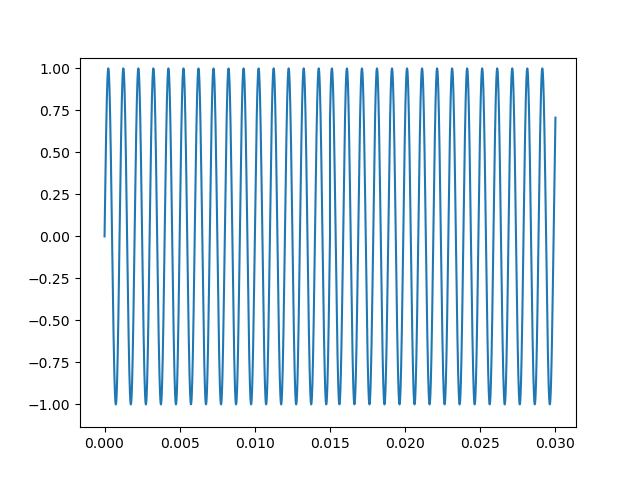

In [19]:
N=3000
t, x = solape(fo,np.pi/4,Ts,0,N,N//2) 
%matplotlib notebook
plt.plot(t,x)

***Ejercicio 20.*** Con el filtro "rc", ajustar los parámetros del bucle a: ($\xi$ = 2;0, wn = 220). ¿Consigue
engancharse el PLL al introducir el error de fase?

In [26]:
xi=2.
wn=220
x1,_=PLL(x,fo,Ts,fi,N,K,xi,wn,0,"rc")

<IPython.core.display.Javascript object>


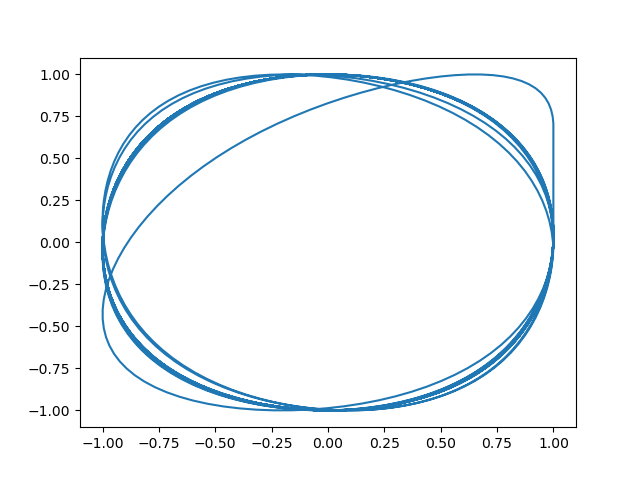

In [27]:
%matplotlib notebook
plt.plot(x1,x)

<IPython.core.display.Javascript object>


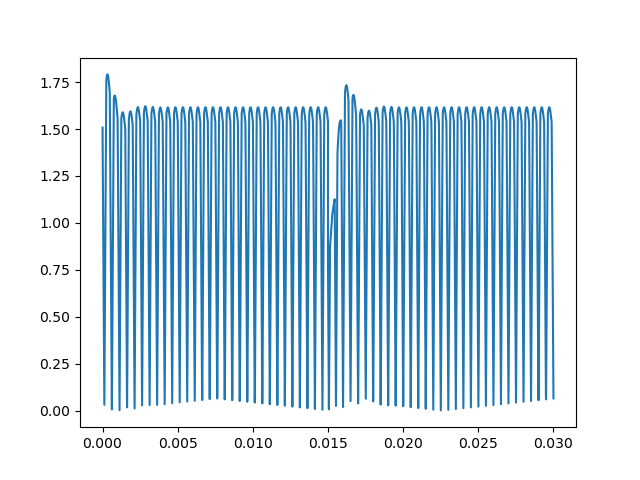

In [28]:
%matplotlib notebook
plt.plot(t,abs(np.arcsin(x1)-np.arcsin(x)))

***Ejercicio 21.*** Repetir el proceso para unos parámetros: ($\xi$ =
$\frac{\sqrt{
2}}{2}$, wn = 220). Comentar las
diferencias que observa.

In [29]:
xi=np.sqrt(2.)/2
wn=220
x2,_=PLL(x,fo,Ts,fi,N,K,xi,wn,0,"rc")

<IPython.core.display.Javascript object>


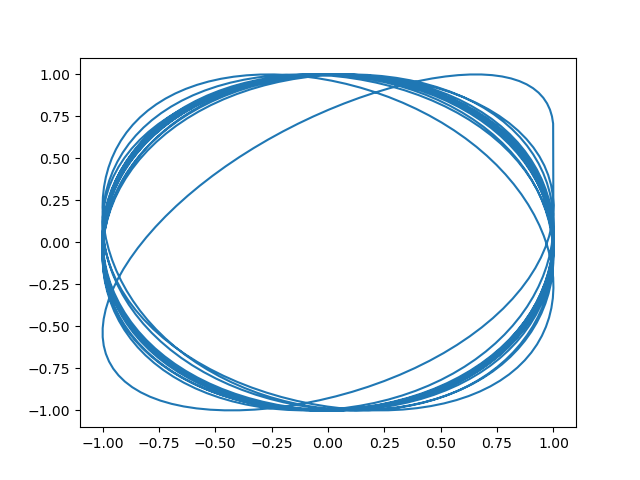

In [30]:
%matplotlib notebook
plt.plot(x2,x)

<IPython.core.display.Javascript object>


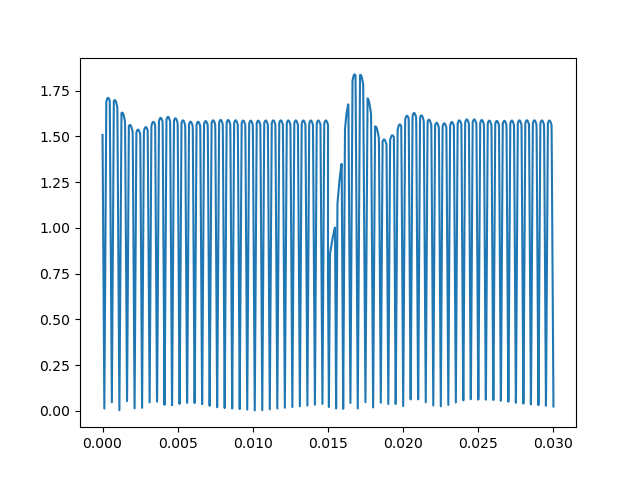

In [31]:
%matplotlib notebook
plt.plot(t,abs(np.arcsin(x2)-np.arcsin(x)))

***Ejercicio 22.*** Con el filtro "lead-lag activo", ajustar los parámetros del bucle a:  ($\xi$ =
2,
wn = 80) ¿Se engancha correctamente el PLL?.

***Ejercicio 23.*** Repetir el proceso para unos parámetros: ($\xi$ =
$\frac{\sqrt{
2}}{2}$, wn = 180) ¿Qué ocurre con
la velocidad de enganche del PLL?

Vamos a trabajar ahora con una señal similar a la anterior, pero que presenta en la muestra N/2
un error de fase de $\pi$. Igual que antes representar la señal de error y el diagrama de Lissajous que se
obtiene en cada caso.

<IPython.core.display.Javascript object>


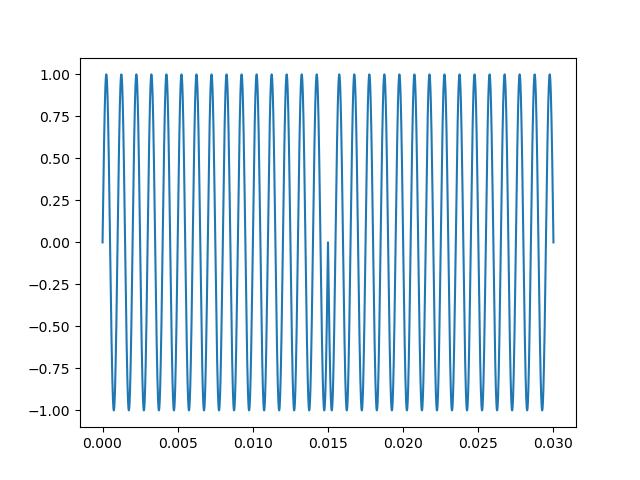

In [32]:
N=3000
t, x = solape(fo,np.pi,Ts,0,N,N//2) 
%matplotlib notebook
plt.plot(t,x)

***Ejercicio 24.*** Con el filtro "rc", ajustar los parámetros del bucle a: ($\xi$ = 2.0, wn = 220 ) ¿Consigue
engancharse el PLL al introducir el error de fase? ¿Por qué?

In [33]:
xi=2.
wn=220
x1,_=PLL(x,fo,Ts,fi,N,K,xi,wn,0,"rc")


<IPython.core.display.Javascript object>


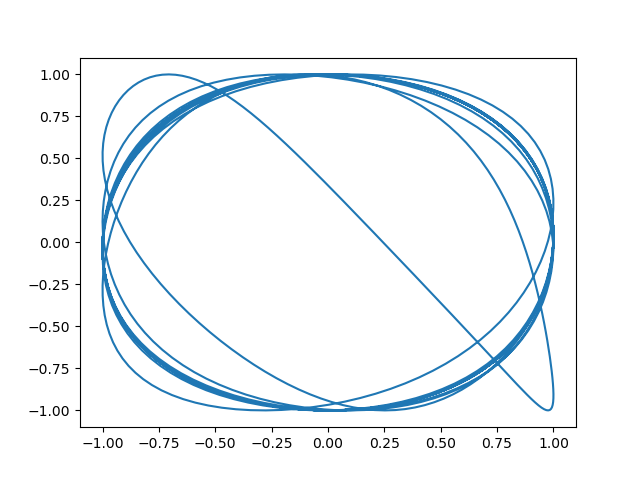

In [34]:
%matplotlib notebook
plt.plot(x1,x)

<IPython.core.display.Javascript object>


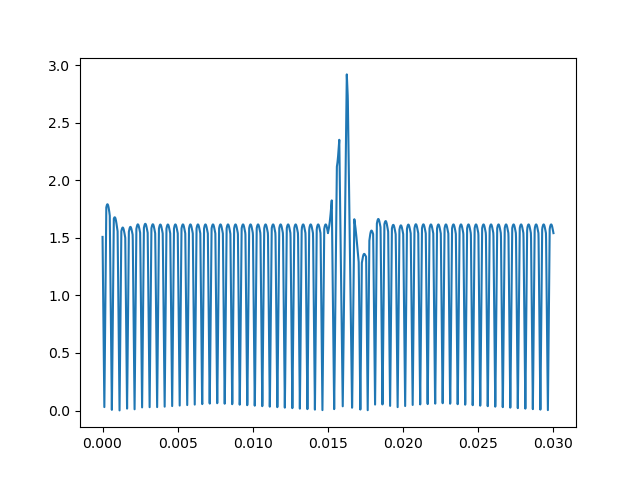

In [35]:
%matplotlib notebook
plt.plot(t,abs(np.arcsin(x1)-np.arcsin(x)))

***Ejercicio 25.*** Con el filtro "lead-lag activo", ajustar los parámetros del bucle a: ($\xi$ =
$\frac{\sqrt{
2}}{2}$,
wn = 180) ¿Se engancha correctamente el PLL? ¿Por qué cree que ocurre esto?

# Errores de frecuencia

Generar ahora una señal de entrada al PLL con el error de fase inicial de $\pi$/2, y un error de
frecuencia del 10 %. Representar en cada caso la señal de error y el diagrama de Lissajous.

In [36]:
fo=1000
Ts=1/(100*fo)
K=1000
N=3000
t,x=fuente(fo+0.1*fo,Ts,0,N)

***Ejercicio 26.*** Con el filtro"rc", ajustar los parámetros del bucle a: ($\xi$ =
$\frac{\sqrt{
2}}{2}$, wn = 220).
¿Consigue engancharse el PLL al introducir el error de frecuencia?.

In [38]:
xi=np.sqrt(2.)/2
wn=220
fi=np.pi/2
xo,_=PLL(x,fo,Ts,fi,N,K,xi,wn,0,"rc")

<IPython.core.display.Javascript object>


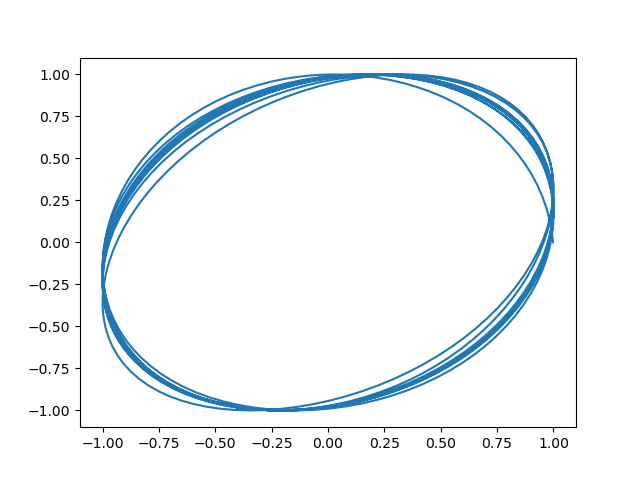

In [39]:
%matplotlib notebook
plt.plot(xo,x)

<IPython.core.display.Javascript object>


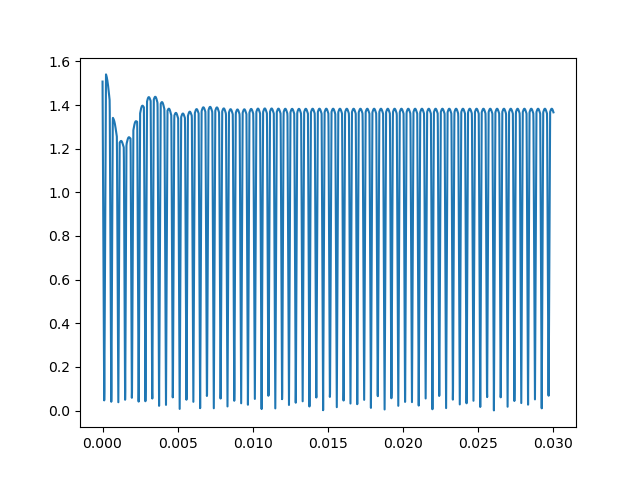

In [40]:
%matplotlib notebook
plt.plot(t,abs(np.arcsin(xo)-np.arcsin(x)))

***Ejercicio 27.*** Repetir el experimento tomando los siguientes parámetros de bucle: $\xi$ =
$\frac{\sqrt{
2}}{2}$,
wn = 450). Interprete el resultado obtenido.

In [41]:
xi=np.sqrt(2.)/2
wn=450
fi=np.pi/2
xo,_=PLL(x,fo,Ts,fi,N,K,xi,wn,0,"rc")

<IPython.core.display.Javascript object>


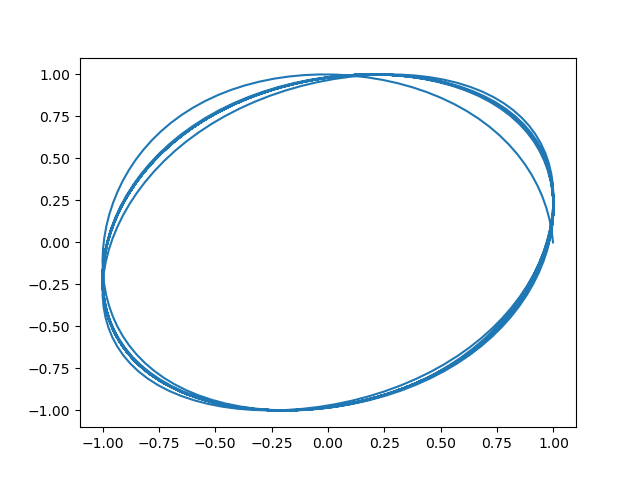

In [42]:
%matplotlib notebook
plt.plot(xo,x)

<IPython.core.display.Javascript object>


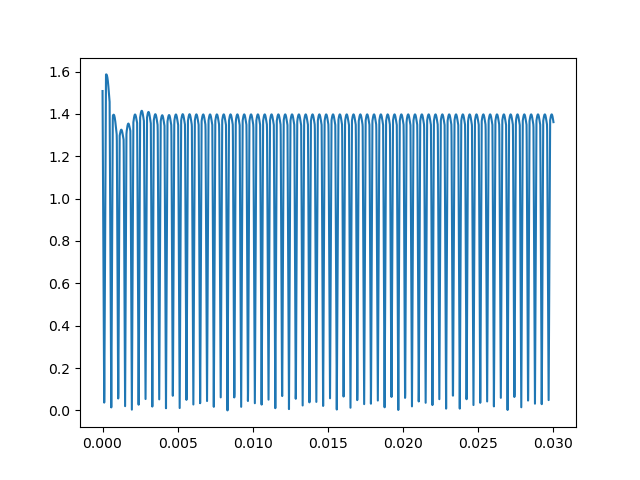

In [43]:
%matplotlib notebook
plt.plot(t,abs(np.arcsin(xo)-np.arcsin(x)))

***Ejercicio 29.*** Con el filtro "lead-lag activo", ajustar los parámetros del bucle a: ($\xi$ =
$\frac{\sqrt{
2}}{2}$,
wn = 180). ¿Se engancha correctamente el PLL?.


***Ejercicio 30.**** Repetir el ejercicio, si reduce la pulsación propia a wn = 120, ¿se engancha el PLL
correctamente?. ¿Por qué?.

***Ejercicio 31.*** Repetir el ejercicio, si reduce la pulsación propia a wn = 80, ¿se engancha el PLL
correctamente?. ¿Por qué?

***Ejercicio 32.*** Para comprobar si el problema es el margen de enganche, reduzca el error de frecuencia
al 3 %. ¿Se engancha ahora correctamente el PLL?. ¿Cual es la relación entre el margen de
enganche y el ancho de banda del filtro?.

# Rampa de frecuencia

Vamos a comprobar el comportamiento del PLL ante una rampa en frecuencia. Como siempre
representar la señal de error y el diagrama de Lissajous.

***Ejercicio 33.*** Construir una función en Python que genere la señal de entrada al PLL, constituida
por una rampa en frecuencia: fuente_var($f_o$, $f_{final}$, Ts, $\text{fase}_{inicial}$, N).

In [20]:
def fuente_var(fo,ff,Ts,fi,N):
    t=np.linspace(0,N*Ts,N)
    x=np.array([np.sin(fi)])
    df=(ff-fo)/N
    for i in range(1,N):
        fo+=df
        x=np.append(x,[np.sin(2*np.pi*fo*t[i]+fi)])
    return t,x

Con la función que acaba de crear, genere una señal con error de fase inicial ($\pi$/2), y una rampa
en frecuencia del 10 %, tomando como frecuencia inicial: fo = 1 kHz. Vamos a tomar esta señal como
entrada al PLL.

In [24]:
fo=1000.
Ts=1./(fo*100.)
N=3000
fi=np.pi/2.
t,x=fuente_var(fo,fo+0.1*fo,Ts,0,N)


%matplotlib notebook
#plt.plot(t,x)
#TF(N,Ts,x,graph=True)

***Ejercicio 34.*** Con el filtro "rc", ajustar los parámetros del bucle a: ($\xi$ =
$\frac{\sqrt{
2}}{2}$, wn = 450).


In [46]:
xi=np.sqrt(2.)/2
wn=450
xo,_=PLL(x,fo,Ts,fi,N,K,xi,wn,0,"rc")

<IPython.core.display.Javascript object>


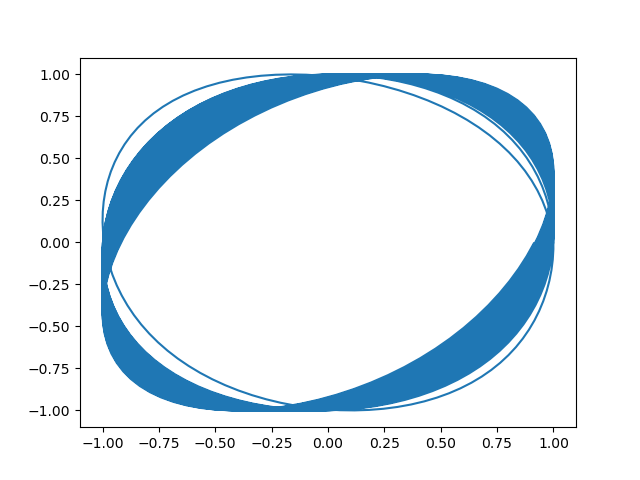

In [47]:
%matplotlib notebook
plt.plot(xo,x)

<IPython.core.display.Javascript object>


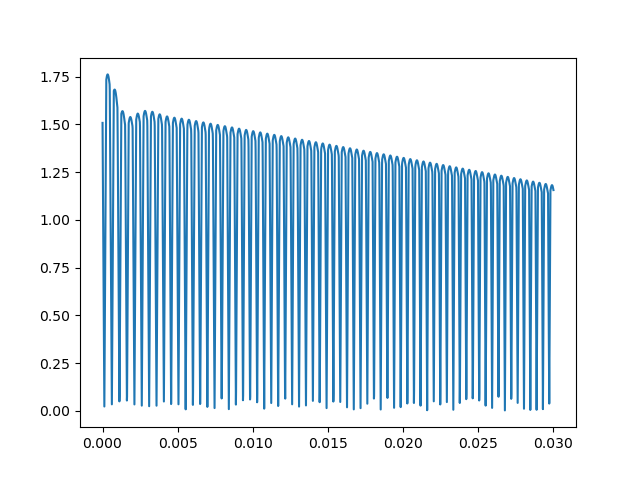

In [48]:
%matplotlib notebook
plt.plot(t,abs(np.arcsin(xo)-np.arcsin(x)))

***Ejercicio 35.*** Con el filtro "lead-lag activo", ajustar los parámetros del bucle a: ($\xi$ =
$\frac{\sqrt{
2}}{2}$,
wn = 180). >Se engancha correctamente el PLL?. ¿Existe un error de fase constante?.

***Ejercicio 36.*** Repetir el ejercicio tomando: ($\xi$ =
$\frac{\sqrt{
2}}{2}$, wn = 280). ¿Qué sucede con el error de
fase del PLL?, ¿por qué?.